In [51]:
import numpy as np
import pandas as pd

%matplotlib widget
import matplotlib.pyplot as plt

from sklearn import base
from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from keras import callbacks

import warnings
warnings.filterwarnings('ignore')

In [3]:
# факторы
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')

# целевые переменные
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100) (5400, 2)


In [4]:
class TensorToMatrix(base.TransformerMixin):
    def __init__(self) -> None:
        """Класс-трансформер, который преобразовывает данные в удобный для обучения вид."""
        pass 
    
    def _check_params(self, tensor):
        """Технический метод для проверки корректности параметров.

        Args:
        ---
            tensor (`ArrayLike`): массив

        Raises:
        ---
            `ValueError`: массив должен иметь размерность 3
        """
        X_shape = len(tensor.shape)
        
        if X_shape != 3:
            raise ValueError(f'There must be 3d array, got {X_shape}d')
    
    def fit(self, tensor):
        """Обучение трансформера.
        
        Args:
        ---
            tensor (`ArrayLike`): массив 
            
        Returns:
        ---
            `self`: обученный трансформер
        """
        self._check_params(tensor)
        
        return self
    
    def transform(self, tensor):
        """Трансформация трехмерного массива в двумерный. 

        Args:
        ---
            tensor (`ArrayLike`): трехмерный массив

        Returns:
        ---
            `NDArray`: двумерный массив 
        """
        self._check_params(tensor)
        
        # перебираем двумерные массивы и заносим их в список
        samples = []
        
        for X in tensor:
            # добавляем в данные также временные отметки
            timesteps = np.arange(X.shape[1])
            
            # не забываем транспонировать массивы, чтобы строки и столбцы были на своих местах
            X_transformed = np.column_stack((X.T, timesteps))
            samples.append(X_transformed)
            
        # результат - вертикально соединенный массив
        return np.row_stack(samples)
    
    def fit_transform(self, tensor, y=None):
        return self.fit(tensor).transform(tensor)


X_train_2d = TensorToMatrix().fit_transform(X_train)
X_test_2d = TensorToMatrix().fit_transform(X_test)

y_train_2d = y_train['class']

y_train_2d.value_counts().plot(kind="barh");

y_train_2d = y_train_2d.values

### Исходный вид

In [7]:
y_train_original = y_train.copy()

y_train_original[['sample_id', 'timestep']] = y_train_original['sample-timestep'].str.split(pat="-", n=1, expand=True).astype(int)
y_train_original = y_train_original.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train_original = y_train_original.sort_index() # на всякий случай
y_train_original = y_train_original.values

print(y_train_original.shape)
y_train_original

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

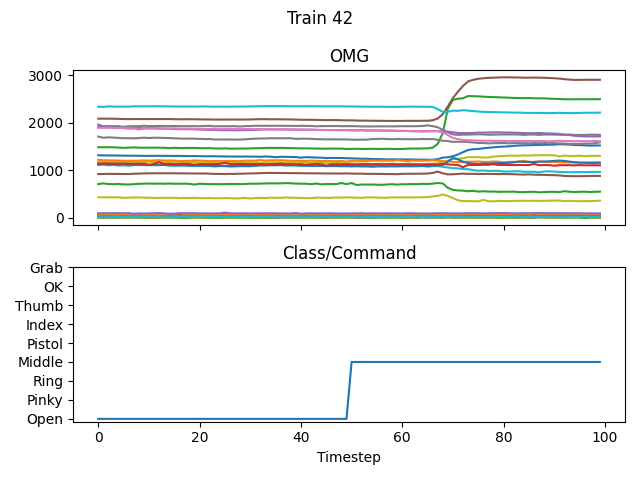

In [11]:
i = 42
fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train_original[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout();

In [52]:
# подготовим тренировочные данные к обучению модели
ss_scaler = preprocessing.StandardScaler()

# обучим скейлеры на всех данных, для лучшей точности
X_full = np.row_stack((X_train_2d, X_test_2d))

X_train_ss = ss_scaler.fit_transform(X_train_2d)
X_test_ss = ss_scaler.transform(X_test_2d)

In [53]:
duration = 100
ts_events = np.arange(0, len(X_train_ss), 100)

y_train_nn = tf.keras.utils.to_categorical(y_train_2d)

X_train_nn = [X_train_ss[ts_event : ts_event + duration] for ts_event in ts_events]
y_train_nn = [y_train_nn[ts_event : ts_event + duration] for ts_event in ts_events]

X_train_nn = np.array([arr for arr in X_train_nn if arr.shape == X_train_nn[0].shape])
y_train_nn = np.array([arr for arr in y_train_nn if arr.shape == y_train_nn[0].shape])


print(X_train_nn.shape, y_train_nn.shape)

(323, 100, 41) (323, 100, 9)


In [160]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(None, n_channels))

x = tf.keras.layers.SimpleRNN(units=369, return_sequences=True, dropout=0.5)(x)
x = tf.keras.layers.SimpleRNN(units=41, return_sequences=True, dropout=0.1)(x)

output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()

input_shape = (100, 41) | output_units = 9
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None, 41)]        0         
                                                                 
 simple_rnn_57 (SimpleRNN)   (None, None, 369)         151659    
                                                                 
 simple_rnn_58 (SimpleRNN)   (None, None, 41)          16851     
                                                                 
 dense_14 (Dense)            (None, None, 9)           378       
                                                                 
Total params: 168888 (659.72 KB)
Trainable params: 168888 (659.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [161]:
m = tf.keras.models.clone_model(model)

m.compile(
    loss="categorical_crossentropy",
    metrics=[Precision(), Recall()],
    optimizer=tf.keras.optimizers.experimental.Adamax()
)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min", patience=50,
    restore_best_weights=True
)

his = m.fit(
    X_train_nn,
    y_train_nn,
    batch_size=5,
    epochs=1000,
    verbose=1,
    validation_split=0.2,
    callbacks=[earlystopping]
)

y_pred_train_nn = m.predict(X_train_nn)
print(y_pred_train_nn.shape)

Epoch 1/1000
52/52 [==============================] - 3s 35ms/step - loss: 1.6784 - precision_20: 0.7615 - recall_20: 0.3172 - val_loss: 1.4500 - val_precision_20: 0.8134 - val_recall_20: 0.3682
Epoch 2/1000
52/52 [==============================] - 2s 29ms/step - loss: 1.2093 - precision_20: 0.8014 - recall_20: 0.5084 - val_loss: 1.0798 - val_precision_20: 0.7928 - val_recall_20: 0.6798
Epoch 3/1000
52/52 [==============================] - 1s 29ms/step - loss: 1.0523 - precision_20: 0.8002 - recall_20: 0.6135 - val_loss: 0.8897 - val_precision_20: 0.8130 - val_recall_20: 0.7365
Epoch 4/1000
52/52 [==============================] - 1s 29ms/step - loss: 0.9834 - precision_20: 0.7952 - recall_20: 0.6416 - val_loss: 0.8326 - val_precision_20: 0.8011 - val_recall_20: 0.7386
Epoch 5/1000
52/52 [==============================] - 2s 29ms/step - loss: 0.9192 - precision_20: 0.7969 - recall_20: 0.6655 - val_loss: 0.8215 - val_precision_20: 0.8130 - val_recall_20: 0.7400
Epoch 6/1000
52/52 [=====

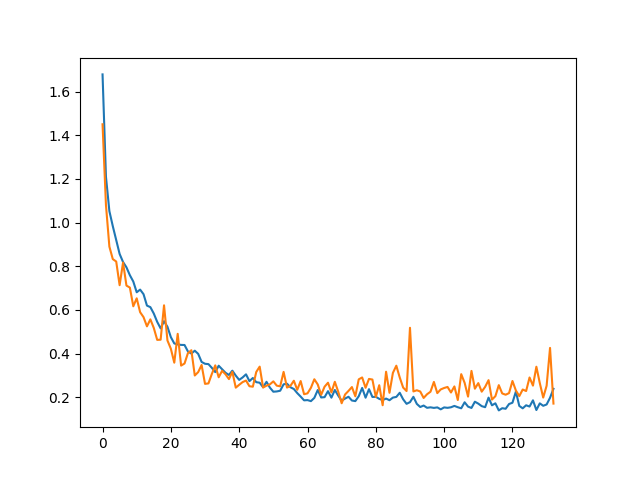

In [162]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(his.history['loss'], color='tab:blue')
ax.plot(his.history['val_loss'], color='tab:orange');

In [163]:
y_pred_train = [arr.argmax(axis=-1) for arr in y_pred_train_nn]

y_pred_train_t = tf.constant(y_pred_train, shape=(323, 100)).numpy()

preds_train = []
for idx, arr in zip(y_train.index, y_pred_train_t):
    
    series = pd.Series(arr)
    preds_train.append(series)
    
preds_train = pd.concat(preds_train)
preds_train = preds_train.reset_index().drop('index', axis=1).values

print(metrics.classification_report(y_train_2d, preds_train, digits=4))

print('Precision:', round(metrics.precision_score(y_train_2d, preds_train, average='weighted'), 5))
print('Recall:   ', round(metrics.recall_score(y_train_2d, preds_train, average='weighted'), 5))
print('F1 score: ', round(metrics.f1_score(y_train_2d, preds_train, average='weighted'), 5))

              precision    recall  f1-score   support

           0     0.9780    0.9543    0.9660     17950
           1     0.9408    0.9533    0.9470      1800
           2     0.9372    0.9872    0.9616      1800
           3     0.9473    0.9578    0.9525      1800
           4     0.8999    0.9914    0.9434      1750
           5     0.9363    0.9233    0.9298      1800
           6     0.8816    0.9222    0.9014      1800
           7     0.9944    0.8928    0.9409      1800
           8     0.8654    0.9822    0.9201      1800

    accuracy                         0.9529     32300
   macro avg     0.9312    0.9516    0.9403     32300
weighted avg     0.9546    0.9529    0.9531     32300

Precision: 0.95463
Recall:    0.95288
F1 score:  0.95313


In [164]:
ts_events_test = np.arange(0, len(X_test_ss), 100)

X_test_nn = [X_test_ss[ts_event : ts_event + duration] for ts_event in ts_events_test]

X_test_nn = np.array([arr for arr in X_test_nn if arr.shape == X_test_nn[0].shape])

X_test_nn.shape

(54, 100, 41)

In [167]:
y_pred_test_nn = []
for i in range(len(X_test_nn)):
    X_test_i = np.expand_dims(X_test_nn[i], axis=0)
    y_pred_test_nn += [m.predict(X_test_i, verbose=0)]
        
y_pred_test = [arr.argmax(axis=-1) for arr in y_pred_test_nn]

np.array(y_pred_test).shape

(54, 1, 100)


In [168]:
y_pred_test_t = tf.constant(y_pred_test, shape=(54, 100)).numpy()

In [169]:
preds_test = []
for idx, arr in zip(y_test.index, y_pred_test_t):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    preds_test.append(series)
    
preds_test = pd.concat(preds_test)
preds_test = preds_test.reset_index()
preds_test.columns = ["sample-timestep", "class"]
preds_test['sample-timestep'] = y_test['sample-timestep']
preds_test.head()

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4


In [120]:
# сохраним результат для отправки на платформу Kaggle
preds_test.to_csv('preds_test.csv', index=False)

In [170]:
preds_test['class'].value_counts()

class
0    2869
5     428
3     364
4     353
2     328
1     326
8     270
6     255
7     207
Name: count, dtype: int64

### Исходный вид

In [171]:
y_test_preds = preds_test.copy()

# подготовим данные
y_test_preds[['sample_id', 'timestep']] = y_test_preds['sample-timestep'].str.split(pat='-',n=1, expand=True).astype(int)
y_test_preds = y_test_preds.pivot(index='sample_id', columns='timestep', values='class')
y_test_index = y_test.index
y_test_preds = y_test_preds.sort_index() # на всякий случай
y_test_preds = y_test_preds.values

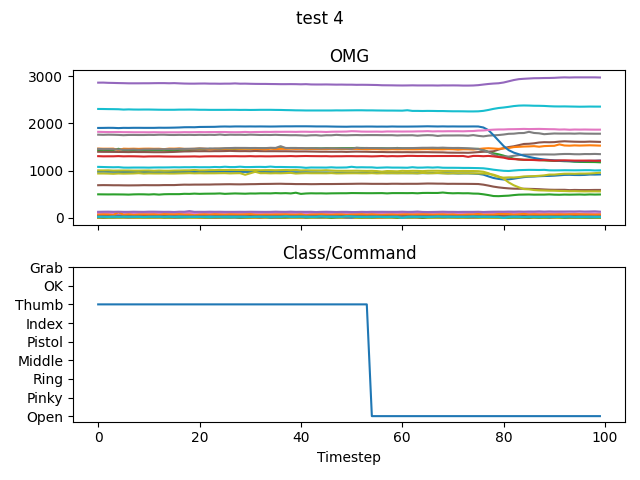

In [176]:
i = 4

fig, axx = plt.subplots(2, 1, sharex=True)

axx[0].plot(X_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_test_preds[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'test {i}')

plt.tight_layout()